## <u>*Calssifications Modelling for gender as a Target Feature*</u>

In [ ]:
%run 3_EDA.ipynb

In [75]:
df5=df.copy()
df5.drop(["clm"],axis=1,inplace=True)

In [76]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)
import seaborn as sns;sns.set()
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from datetime import datetime,time
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import (
    r2_score,accuracy_score,roc_auc_score,auc,roc_curve,precision_score,
    recall_score,precision_recall_curve,r2_score,classification_report,RocCurveDisplay,
    confusion_matrix,f1_score,ConfusionMatrixDisplay
    )


from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier,XGBRFClassifier
import warnings
from sklearn.ensemble import (
    AdaBoostClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,BaggingClassifier
)

from hyperopt import fmin,tpe,STATUS_OK,Trials,hp
from sklearn.utils.multiclass import unique_labels
import plotclassification ,plotly
# import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassificationReport
   

### *A.*<br> <u>*Models Preparation :*</u>

#### *A.1. <br> <u>Classification Models to use :*</u>

In [77]:
models = {
                "RandomForestClassifier": RandomForestClassifier(),
                "DecisionTreeClassifier": DecisionTreeClassifier(),
                "GradientBoostingClassifier": GradientBoostingClassifier(),
                "XGBClassifier": XGBClassifier(),
                "CatBoostClassifier": CatBoostClassifier(verbose=False),
                "AdaBoostClassifier": AdaBoostClassifier(),
                "BaggingClassifier":BaggingClassifier()
            }

#### *A.2. <br> <u>Classification Models spaces preperartion to use in hyperopt :*</u>

In [78]:
space_xgboost_clf  = {
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
}

space_rf_clf = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
    #'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
    #'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2', None]),
    'bootstrap': hp.choice('bootstrap', [True, False]),
}


space_GradientBoosting_clf = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
}

space_DT = {
    #'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'splitter': hp.choice('splitter', ['best', 'random']),
    'max_depth': hp.choice('depth', range(1, 15)),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
    #'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2', None]),
}



space_Bagging_clf = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_samples': hp.uniform('max_samples', 0.1, 1.0),
    'max_features': hp.uniform('max_features', 0.1, 1.0),
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'bootstrap_features': hp.choice('bootstrap_features', [True, False]),
}

space_catboost_clf = {
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'iterations': hp.quniform('iterations', 50, 200, 1),
    'depth': hp.choice('depth', range(1, 15)),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0.1, 10),
    'border_count': hp.choice('border_count', [32, 64, 128, 256]),
    'bagging_temperature': hp.uniform('bagging_temperature', 0, 1),
    'random_strength': hp.uniform('random_strength', 0, 1),
}

---

### *B. <br> <u>Data preparation:*</u>

#### *B.1. <br> <u>Solving imbalanced issue if exist :*</u>

In [79]:
print(df5.groupby("gender")["gender"].count())
print(df5.groupby("gender")["gender"].count()/df5["gender"].count())

gender
F    38603
M    29253
Name: gender, dtype: int64
gender
F    0.568896
M    0.431104
Name: gender, dtype: float64


> *The data balnance between between genders are acceptable*

#### *B.2. <br> <u>LabelEncoding for categorical features :*</u>

In [80]:
LabelEncoder_cat = LabelEncoder()
for col in df5:
    if col in ["numclaims","veh_body","veh_age","gender","area","agecat"]:
        df5[col]=LabelEncoder_cat.fit_transform(df5[col])

#### *B.3. <br> <u>Define x & y features :*</u>

In [81]:
x=df5.drop("gender",axis=1)
y=df5["gender"]

#### *B.4. <br> <u>data splitting (training & testing) :*</u>

In [82]:
xtrain,xtest, ytrain, ytest = train_test_split(x, y, train_size=0.7, test_size=0.3)

---

### *C. <br> <u>Modelling:*</u>

#### *C.1 <br> <u>* *XGBClassifier:*</u>

In [58]:
def model_XGBClassifier(space_xgboost_clf):
    accuracyList=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("XGBClassifier",XGBClassifier( 
               learning_rate=float(space_xgboost_clf['learning_rate']),
               n_estimators=int(space_xgboost_clf['n_estimators']),
               max_depth=int(space_xgboost_clf['max_depth']),
               min_child_weight=int(space_xgboost_clf['min_child_weight']),
               subsample=float(space_xgboost_clf["subsample"]),
               gamma=float(space_xgboost_clf['gamma']),
               colsample_bytree=float(space_xgboost_clf['colsample_bytree'])                                      

                                    ))

                                    ])
                                  
    model_opt.fit(xtrain,ytrain)
    Accuracy_result=accuracy_score(ytest,model_opt.predict(xtest))
    accuracyList.append(Accuracy_result)                         
    mean_Accuracy_result=np.mean(accuracyList)                          
    return { 
           'loss': mean_Accuracy_result,
           'status': STATUS_OK
            } 

In [59]:
def model_XGBClassifier_best(best_model_XGBClassifier):
    y_model_XGBClassifier_best=[]
    Accuracy_list=[]
    model_opt = Pipeline(
        steps=[
           #('preprocessor', preprocessor),
            ("XGBClassifier",XGBClassifier( 
               learning_rate=float(best_model_XGBClassifier['learning_rate']),
               n_estimators=int(best_model_XGBClassifier['n_estimators']),
               max_depth=int(best_model_XGBClassifier['max_depth']),
               min_child_weight=int(best_model_XGBClassifier['min_child_weight']),
               subsample=float(best_model_XGBClassifier["subsample"]),
               gamma=float(best_model_XGBClassifier['gamma']),
               colsample_bytree=float(best_model_XGBClassifier['colsample_bytree'])                                      

                                    ))

                                    ])
                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    y_model_XGBClassifier_best.append(y_pred)

    Accuracy_result=accuracy_score(ytest,y_pred)
    Accuracy_list.append(Accuracy_result)
   

    print('model_XGBClassifier_best Accuracy_result:',  np.mean(Accuracy_list))

In [60]:
best_model_XGBClassifier = fmin(fn=model_XGBClassifier, space=space_xgboost_clf, algo=tpe.suggest, max_evals=10)
model_XGBClassifier_best(best_model_XGBClassifier)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 10/10 [00:29<00:00,  2.95s/trial, best loss: 0.5866286780959866]
model_XGBClassifier_best Accuracy_result: 0.5949304907402859


---

#### *C.2 <br> <u>* *RandomForestClassifier:*</u>

In [83]:
def model_rf_clf(space_rf_clf):
    accuracyList=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("RandomForestClassifier",RandomForestClassifier(              
                                    n_estimators=int(space_rf_clf['n_estimators']),
                                    #criterion=int(space_rf_clf['criterion']),                                                       
                                    max_depth=int(space_rf_clf['max_depth']),
                                    min_samples_split=float(space_rf_clf['min_samples_split']),
                                    min_samples_leaf=float(space_rf_clf['min_samples_leaf']),
                                    #max_features=float(space_rf_clf["max_features"]),
                                    bootstrap=int(space_rf_clf['bootstrap'])

                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    Accuracy_result=accuracy_score(ytest,y_pred)
    accuracyList.append(Accuracy_result)                         
    mean_Accuracy_result=np.mean(accuracyList)                          
    return { 
           'loss': mean_Accuracy_result,
           'status': STATUS_OK
            } 

In [84]:
def model_rf_clf_best(best_model_rf_clf):
    y_model_rf_clf_best=[]
    Accuracy_list=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
              ("RandomForestClassifier",RandomForestClassifier(              
                                    n_estimators=int(best_model_rf_clf['n_estimators']),
                                    #criterion=int(best_model_rf_clf['criterion']),                                                       
                                    max_depth=int(best_model_rf_clf['max_depth']),
                                    min_samples_split=float(best_model_rf_clf['min_samples_split']),
                                    min_samples_leaf=float(best_model_rf_clf['min_samples_leaf']),
                                    #max_features=float(space_rf_clf["max_features"]),
                                    bootstrap=int(best_model_rf_clf['bootstrap'])

                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    y_model_rf_clf_best.append(y_pred)

    Accuracy_result=accuracy_score(ytest,y_pred)
    Accuracy_list.append(Accuracy_result)
   

    print('model_rf_clf_best Accuracy_result:',  np.mean(Accuracy_list))

In [85]:
best_model_rf_clf = fmin(fn=model_rf_clf, space=space_rf_clf, algo=tpe.suggest, max_evals=10)
model_rf_clf_best(best_model_rf_clf)

100%|██████████| 10/10 [00:10<00:00,  1.08s/trial, best loss: 0.5699268065039053]
model_rf_clf_best Accuracy_result: 0.5879550031930049


---

#### *C.3 <br> <u>* *GradientBoostingClassifier:*</u>

In [87]:
def model_GradientBoosting_clf(space_GradientBoosting_clf):
    accuracyList=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("GradientBoostingClassifier",GradientBoostingClassifier(              
                                    n_estimators=int(space_GradientBoosting_clf['n_estimators']),                                                       
                                    learning_rate=float(space_GradientBoosting_clf['learning_rate']),
                                    max_depth=int(space_GradientBoosting_clf['max_depth']),
                                    min_samples_split=float(space_GradientBoosting_clf['min_samples_split']),
                                    min_samples_leaf=float(space_GradientBoosting_clf['min_samples_leaf']),
                                    subsample=float(space_GradientBoosting_clf['subsample'])

                                    ))

                                    ])
                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    Accuracy_result=accuracy_score(ytest,y_pred)
    accuracyList.append(Accuracy_result)                         
    mean_Accuracy_result=np.mean(accuracyList)                          
    return { 
           'loss': mean_Accuracy_result,
           'status': STATUS_OK
            } 

In [65]:
def model_GradientBoosting_clf_best(best_model_GradientBoosting_clf):
    y_GradientBoosting_clf_best=[]
    Accuracy_list=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("GradientBoostingClassifier",GradientBoostingClassifier(              
                                    n_estimators=int(best_model_GradientBoosting_clf['n_estimators']),                                                       
                                    learning_rate=float(best_model_GradientBoosting_clf['learning_rate']),
                                    max_depth=int(best_model_GradientBoosting_clf['max_depth']),
                                    min_samples_split=float(best_model_GradientBoosting_clf['min_samples_split']),
                                    min_samples_leaf=float(best_model_GradientBoosting_clf['min_samples_leaf']),
                                    subsample=float(best_model_GradientBoosting_clf['subsample'])


                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    y_GradientBoosting_clf_best.append(y_pred)

    Accuracy_result=accuracy_score(ytest,y_pred)
    Accuracy_list.append(Accuracy_result)
   

    print('model_GradientBoosting_clf_best Accuracy_result:',  np.mean(Accuracy_list))

In [88]:
best_model_GradientBoosting_clf = fmin(fn=model_GradientBoosting_clf, space=space_GradientBoosting_clf, algo=tpe.suggest, max_evals=10)
model_GradientBoosting_clf_best(best_model_GradientBoosting_clf)

100%|██████████| 10/10 [00:21<00:00,  2.16s/trial, best loss: 0.5669302942476789]
model_GradientBoosting_clf_best Accuracy_result: 0.5678145109790245


----

#### *C.4 <br> <u>* *DecisionTreeClassifier:*</u>

In [89]:
def model_DT(space_DT):
    accuracyList=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("BaggingClassifier",DecisionTreeClassifier(              
                                    #criterion=int(space_DT['criterion']),                                                       
                                    splitter=str(space_DT['splitter']),
                                    max_depth=int(space_DT['max_depth']),
                                    min_samples_split=float(space_DT['min_samples_split']),
                                    min_samples_leaf=float(space_DT['min_samples_leaf']),
                                    #max_features=int(space_DT['max_features'])

                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    Accuracy_result=accuracy_score(ytest,y_pred)
    accuracyList.append(Accuracy_result)                         
    mean_Accuracy_result=np.mean(accuracyList)                          
    return { 
           'loss': mean_Accuracy_result,
           'status': STATUS_OK
            } 


In [90]:
def model_DT_best(best_model_DT):
    y_DT_best=[]
    Accuracy_list=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("BaggingClassifier",DecisionTreeClassifier(              
                                    #criterion=int(best_model_DT['criterion']),                                                       
                                    #splitter=str(best_model_DT['splitter']),
                                    max_depth=int(best_model_DT['depth']),
                                    min_samples_split=float(best_model_DT['min_samples_split']),
                                    min_samples_leaf=float(best_model_DT['min_samples_leaf']),
                                    #max_features=int(best_model_DT['max_features'])

                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    y_DT_best.append(y_pred)

    Accuracy_result=accuracy_score(ytest,y_pred)
    Accuracy_list.append(Accuracy_result)
   

    print('model_DT_best Accuracy_result:',  np.mean(Accuracy_list))

In [91]:
best_model_DT = fmin(fn=model_DT, space=space_DT, algo=tpe.suggest, max_evals=10)
model_DT_best(best_model_DT)

100%|██████████| 10/10 [00:00<00:00, 45.25trial/s, best loss: 0.5681092498894729]
model_DT_best Accuracy_result: 0.5681092498894729


---

#### *C.5 <br> <u>* *BaggingClassifier:*</u>

In [92]:
def model_Bagging(space_Bagging_clf):
    base_classifier =DecisionTreeClassifier()
    accuracyList=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("BaggingClassifier",BaggingClassifier(base_estimator=base_classifier,                
                                    n_estimators=int(space_Bagging_clf['n_estimators']),
                                    bootstrap=int(space_Bagging_clf["bootstrap"]),                                                       
                                    bootstrap_features=int(space_Bagging_clf['bootstrap_features']),
                                    max_samples=float(space_Bagging_clf["max_samples"]),
                                    max_features=float(space_Bagging_clf["max_features"])

                                    ))

                                    ])
                                              
                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    Accuracy_result=accuracy_score(ytest,y_pred)
    accuracyList.append(Accuracy_result)                         
    mean_Accuracy_result=np.mean(accuracyList)                          
    return { 
           'loss': mean_Accuracy_result,
           'status': STATUS_OK
            } 

In [93]:
def model_Bagging_best(best_model_BaggingClassifier):
    base_classifier =DecisionTreeClassifier()
    y_Bagging_best=[]
    Accuracy_list=[]

    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("CatBoostRegressor",BaggingClassifier(base_estimator=base_classifier,                
                                    n_estimators=int(best_model_BaggingClassifier['n_estimators']),
                                    bootstrap=int(best_model_BaggingClassifier["bootstrap"]),                                                       
                                    bootstrap_features=int(best_model_BaggingClassifier['bootstrap_features']),
                                    max_samples=float(best_model_BaggingClassifier["max_samples"]),
                                    max_features=float(best_model_BaggingClassifier["max_features"])

                                    ))

                                    ])
                                              
                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    y_Bagging_best.append(y_pred)

    Accuracy_result=accuracy_score(ytest,y_pred)
    Accuracy_list.append(Accuracy_result)
   

    print('model_Bagging_best Accuracy_result:',  np.mean(Accuracy_list))

In [94]:
best_model_BaggingClassifier=fmin(fn=model_Bagging, space=space_Bagging_clf, algo=tpe.suggest, max_evals=10)
model_Bagging_best(best_model_BaggingClassifier)

100%|██████████| 10/10 [01:04<00:00,  6.42s/trial, best loss: 0.5677162646755416]
model_Bagging_best Accuracy_result: 0.5684531119516628


---

#### *C.6 <br> <u>* *CatBoostClassifier:*</u>

In [95]:
def model_catboost(space_catboost_clf):
    accuracyList=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("CatBoostRegressor",CatBoostClassifier(
                                    learning_rate=float(space_catboost_clf['learning_rate']),
                                    depth=int(space_catboost_clf["depth"]),                                                       
                                    iterations=int(space_catboost_clf['iterations']),
                                    l2_leaf_reg=float(space_catboost_clf["l2_leaf_reg"]),
                                    border_count=int(space_catboost_clf["border_count"]),
                                    bagging_temperature=float(space_catboost_clf["bagging_temperature"]),
                                    random_strength=float(space_catboost_clf["random_strength"])

                                    ))

                                    ])
                                              
                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    Accuracy_result=accuracy_score(ytest,y_pred)
    accuracyList.append(Accuracy_result)                         
    mean_Accuracy_result=np.mean(accuracyList)                          
    return { 
           'loss': mean_Accuracy_result,
           'status': STATUS_OK
            } 

In [96]:
def model_catboost_best(best_model_catboost):
    y_CatBoostClassifier_best=[]
    Accuracy_list=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("CatBoostRegressor",CatBoostClassifier(
                                    learning_rate=float(best_model_catboost['learning_rate']),
                                    depth=int(best_model_catboost["depth"]),                                                       
                                    iterations=int(best_model_catboost['iterations']),
                                    l2_leaf_reg=float(best_model_catboost["l2_leaf_reg"]),
                                    border_count=int(best_model_catboost["border_count"]),
                                    bagging_temperature=float(best_model_catboost["bagging_temperature"]),
                                    random_strength=float(best_model_catboost["random_strength"])

                                    ))

                                    ])
                                              
                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    y_CatBoostClassifier_best.append(y_pred)

    Accuracy_result=accuracy_score(ytest,y_pred)
    Accuracy_list.append(Accuracy_result)
    print('model_catboost_best Accuracy_result:', Accuracy_result)


In [97]:
best_model_catboost = fmin(fn=model_catboost, space=space_catboost_clf, algo=tpe.suggest, max_evals=10)
model_catboost_best(best_model_catboost)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]0:	learn: 0.6912237	total: 154ms	remaining: 21.8s
1:	learn: 0.6893779	total: 162ms	remaining: 11.4s
2:	learn: 0.6875881	total: 169ms	remaining: 7.84s
3:	learn: 0.6858787	total: 177ms	remaining: 6.11s
4:	learn: 0.6842203	total: 184ms	remaining: 5.05s
5:	learn: 0.6826266	total: 191ms	remaining: 4.34s
6:	learn: 0.6810888	total: 199ms	remaining: 3.84s
7:	learn: 0.6796161	total: 206ms	remaining: 3.45s
8:	learn: 0.6781897	total: 214ms	remaining: 3.16s
9:	learn: 0.6768182	total: 221ms	remaining: 2.92s
10:	learn: 0.6754899	total: 229ms	remaining: 2.72s
11:	learn: 0.6742165	total: 235ms	remaining: 2.55s
12:	learn: 0.6729854	total: 243ms	remaining: 2.42s
13:	learn: 0.6717704	total: 250ms	remaining: 2.29s
14:	learn: 0.6706273	total: 257ms	remaining: 2.18s
15:	learn: 0.6695025	total: 265ms	remaining: 2.09s
16:	learn: 0.6684373	total: 274ms	remaining: 2.02s
17:	learn: 0.6674046	total: 282ms	remaining: 1.94s
18:	learn: 0.6664153	total: 289ms	rema

---

### *D <br> <u>* *running Results:*</u>

In [ ]:
best_model_XGBClassifier = fmin(fn=model_XGBClassifier, space=space_xgboost_clf, algo=tpe.suggest, max_evals=10)
best_model_rf_clf = fmin(fn=model_rf_clf, space=space_rf_clf, algo=tpe.suggest, max_evals=10)
best_model_GradientBoosting_clf = fmin(fn=model_GradientBoosting_clf, space=space_GradientBoosting_clf, algo=tpe.suggest, max_evals=10)
best_model_DT = fmin(fn=model_DT, space=space_DT, algo=tpe.suggest, max_evals=10)
best_model_BaggingClassifier=fmin(fn=model_Bagging, space=space_Bagging_clf, algo=tpe.suggest, max_evals=10)
best_model_catboost = fmin(fn=model_catboost, space=space_catboost_clf, algo=tpe.suggest, max_evals=10)

In [129]:
model_XGBClassifier_best(best_model_XGBClassifier)
model_rf_clf_best(best_model_rf_clf)
model_GradientBoosting_clf_best(best_model_GradientBoosting_clf)
model_DT_best(best_model_DT)
model_Bagging_best(best_model_BaggingClassifier)
model_catboost_best(best_model_catboost)

model_XGBClassifier_best Accuracy_result: 0.6268605393722061
model_rf_clf_best Accuracy_result: 0.567765387827283
model_GradientBoosting_clf_best Accuracy_result: 0.567765387827283
model_DT_best Accuracy_result: 0.567765387827283
0:	learn: 0.6398894	total: 13.6ms	remaining: 1.27s
1:	learn: 0.6329025	total: 25.3ms	remaining: 1.18s
2:	learn: 0.6293018	total: 37ms	remaining: 1.14s
3:	learn: 0.6252640	total: 48.4ms	remaining: 1.1s
4:	learn: 0.6220854	total: 60.3ms	remaining: 1.08s
5:	learn: 0.6204518	total: 72.7ms	remaining: 1.08s
6:	learn: 0.6183866	total: 85.1ms	remaining: 1.07s
7:	learn: 0.6156961	total: 96.4ms	remaining: 1.05s
8:	learn: 0.6143913	total: 108ms	remaining: 1.03s
9:	learn: 0.6117443	total: 119ms	remaining: 1.01s
10:	learn: 0.6117418	total: 122ms	remaining: 933ms
11:	learn: 0.6102378	total: 134ms	remaining: 926ms
12:	learn: 0.6087394	total: 146ms	remaining: 918ms
13:	learn: 0.6072083	total: 157ms	remaining: 908ms
14:	learn: 0.6059813	total: 169ms	remaining: 903ms
15:	learn:

### *D.1 <br> <u>* *best Results:*</u>

> *XGBClassifier has the highest accuracy score*

In [98]:
y_CatBoostClassifier_best=[]
Accuracy_list=[]
model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("CatBoostRegressor",CatBoostClassifier(
                                    learning_rate=float(best_model_catboost['learning_rate']),
                                    depth=int(best_model_catboost["depth"]),                                                       
                                    iterations=int(best_model_catboost['iterations']),
                                    l2_leaf_reg=float(best_model_catboost["l2_leaf_reg"]),
                                    border_count=int(best_model_catboost["border_count"]),
                                    bagging_temperature=float(best_model_catboost["bagging_temperature"]),
                                    random_strength=float(best_model_catboost["random_strength"])

                                    ))

                                    ])
                                              
                                  
model_opt.fit(xtrain,ytrain)
y_pred=model_opt.predict(xtest)
y_CatBoostClassifier_best.append(y_pred)

Accuracy_result=accuracy_score(ytest,y_pred)
Accuracy_list.append(Accuracy_result)
print('model_catboost_best Accuracy_result:', Accuracy_result)

0:	learn: 0.6684271	total: 33.8ms	remaining: 6.08s
1:	learn: 0.6568837	total: 59.7ms	remaining: 5.34s
2:	learn: 0.6510500	total: 83.5ms	remaining: 4.95s
3:	learn: 0.6478790	total: 109ms	remaining: 4.82s
4:	learn: 0.6459765	total: 142ms	remaining: 5.01s
5:	learn: 0.6446824	total: 169ms	remaining: 4.92s
6:	learn: 0.6436937	total: 193ms	remaining: 4.8s
7:	learn: 0.6428876	total: 216ms	remaining: 4.67s
8:	learn: 0.6422782	total: 237ms	remaining: 4.54s
9:	learn: 0.6417318	total: 260ms	remaining: 4.45s
10:	learn: 0.6412631	total: 282ms	remaining: 4.35s
11:	learn: 0.6408706	total: 304ms	remaining: 4.28s
12:	learn: 0.6404836	total: 326ms	remaining: 4.22s
13:	learn: 0.6401533	total: 350ms	remaining: 4.17s
14:	learn: 0.6398276	total: 374ms	remaining: 4.14s
15:	learn: 0.6395215	total: 396ms	remaining: 4.08s
16:	learn: 0.6392457	total: 418ms	remaining: 4.03s
17:	learn: 0.6389773	total: 439ms	remaining: 3.98s
18:	learn: 0.6386892	total: 460ms	remaining: 3.92s
19:	learn: 0.6384097	total: 481ms	remai

In [99]:
print(classification_report(ytest,y_pred))

              precision    recall  f1-score   support

           0       0.63      0.76      0.69     11602
           1       0.56      0.40      0.47      8755

    accuracy                           0.61     20357
   macro avg       0.60      0.58      0.58     20357
weighted avg       0.60      0.61      0.60     20357



In [103]:
print("- Accuracy : ",
      accuracy_score(ytest, y_pred))
print('='*35)

print("- Precision Score \n (Positive Predictive Power) = True Positives / (True Positives + False Positives) :\n ", 
      precision_score(ytest, y_pred, average='weighted'))
print('='*35)
print("- Recall Score \n (True Positive Rate)  = True Positives / (True Positives + False Negatives) :\n ",
      recall_score(ytest, y_pred, average='weighted'))
print('='*35)
print("- F1-Score: ",
      f1_score(ytest, y_pred, average='weighted'))
print('='*35)

- Accuracy :  0.6083411111656923
- Precision Score 
 (Positive Predictive Power) = True Positives / (True Positives + False Positives) :
  0.6002549362170848
- Recall Score 
 (True Positive Rate)  = True Positives / (True Positives + False Negatives) :
  0.6083411111656923
- F1-Score:  0.5951110764999719


In [104]:
unique_labels(ytest)
labels=unique_labels(ytest)
col_names=[f"predicted{label}"for label in labels ]
index_names=[f"Actual{label}"for label in labels ]
pd.DataFrame(confusion_matrix(ytest, y_pred),columns=col_names,index=index_names)

,predicted0,predicted1
Actual0,8845,2757
Actual1,5216,3539


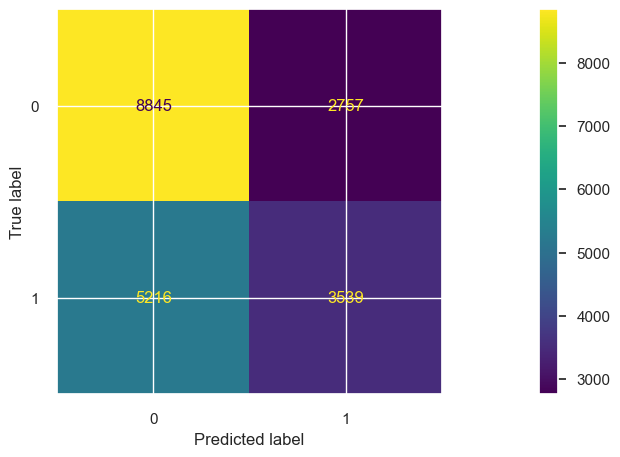

In [105]:
matplotlib.rcParams["figure.figsize"]=(25,5)
ConfusionMatrixDisplay(confusion_matrix(ytest,y_pred)).plot()

##### *C.1.9*<br> <u>*ROC-CURVE :*</u>

* ##### *Area Under Curve (auc)*

In [151]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(ytest, model_opt.predict_proba(xtest)[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(ytest, model_opt.predict_proba(xtest)[:,0], pos_label=1)
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(ytest))]
p_fpr, p_tpr, _ = roc_curve(ytest, random_probs, pos_label=1)

In [152]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(ytest, model_opt.predict_proba(xtest)[:,1])
auc_score2 = roc_auc_score(ytest, model_opt.predict_proba(xtest)[:,0])

print(auc_score1,auc_score2)

0.6195486490788971 0.38045135092110294


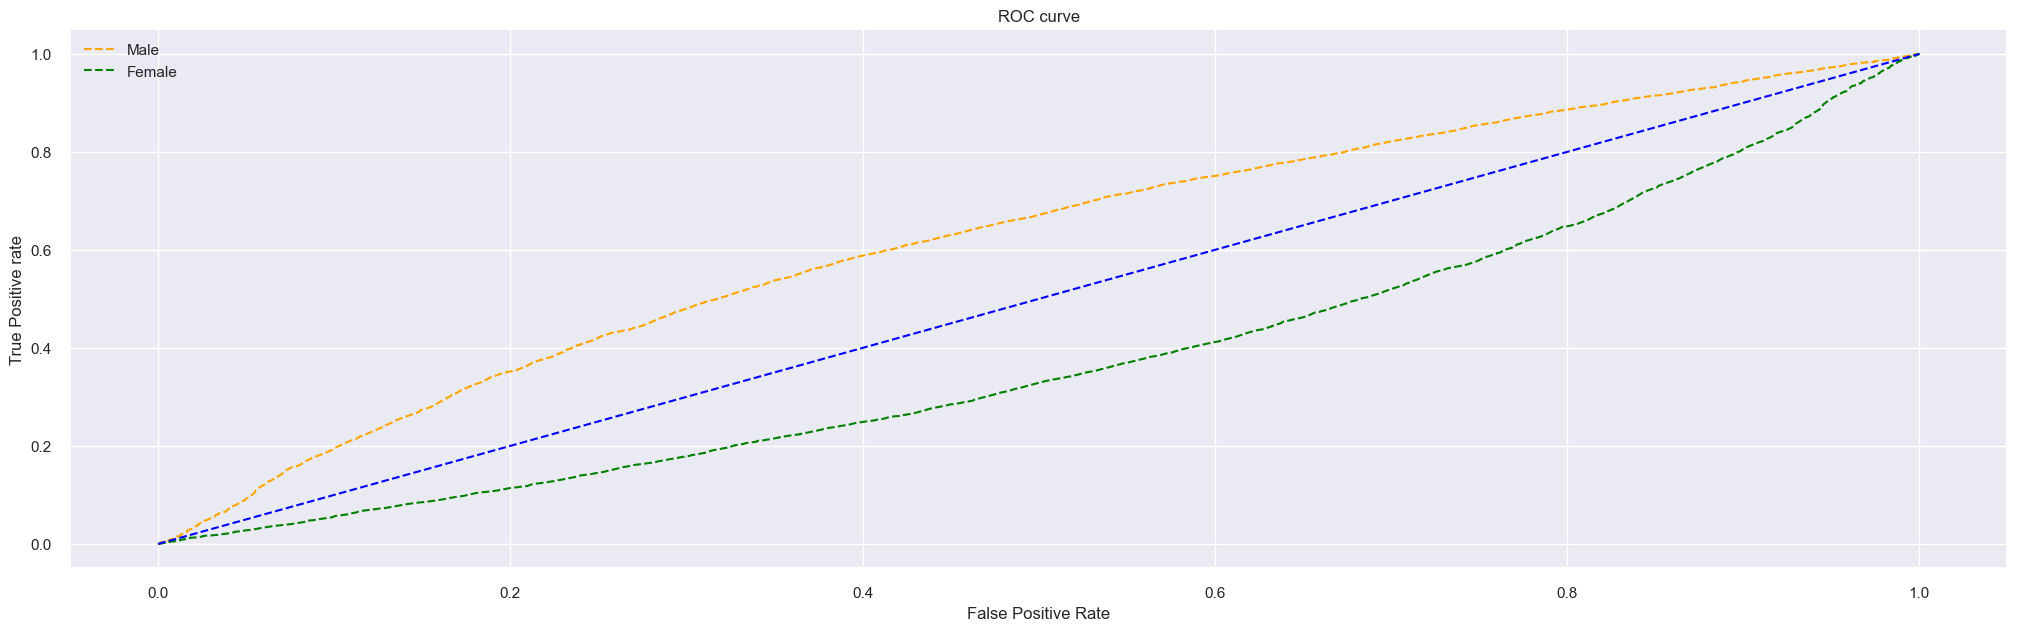

In [155]:
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Male')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Female')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.show();